<a href="https://colab.research.google.com/github/TonyKimisintheHouse/Self-Study-ML-Fundamentals-and-DL/blob/master/notes/PRML_Chapter_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1234)

In [0]:
def create_toy_data(func, sample_size, std):
  x = np.linspace(0, 1, sample_size)
  t = func(x) + np.random.normal(scale = std, size = x.shape)
  return x, t

def func(x):
  return np.sin(2 * np.pi * x)

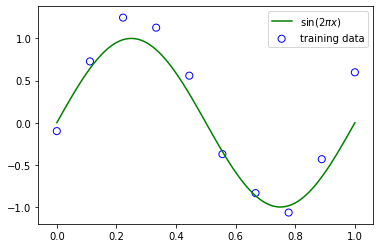

In [10]:
x_train, y_train = create_toy_data(func, 10, 0.25)
x_test = np.linspace(0, 1, 100)
y_test = func(x_test)

plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s = 50, label = "training data")
plt.plot(x_test, y_test, c ="g", label="$\sin(2\pi x)$")
plt.legend()
plt.show()